In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from src.linear_regression import LinearRegression

from src.contributions import Contributions
from src.utils import geometric_adstock, saturation, mean_scaling

# Data simulation
This DGP will be really similar to the [pymc-marketing](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html) one.

$$
Y_t= \mu + X_{1t} \beta_1 + X_{2y} \beta_2 + \sum^{C}_{c=1} M_c \gamma_{ct} + \epsilon
$$
where $Y_t$ represent weekly sales, $\mu$ is the intercept, $\beta_1,...,\beta_3$ are coefficients associated to media tactics, $\gamma$ is associated to the control variables, and $\epsilon$ is an error term that we assume $N(0,1)$. Now let's simulate the data.

In [2]:
seed = 73815

# Option 1: Use global np.random (simpler)
np.random.seed(seed)

# Option 2: Use generator consistently (recommended)
rng = np.random.default_rng(seed=seed)

# data range
min_date = pd.to_datetime('1997-01-01')
max_date = pd.to_datetime('1999-12-31')

df = pd.DataFrame(
    data = {"date_week" : pd.date_range(start=min_date, end=max_date, freq="W-MON")}
)

df['day_of_year'] = df['date_week'].dt.dayofyear

n = df.shape[0]

x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

df['x1_sat_media_cost'] = rng.normal(loc = 1, scale = 0.5, size = n)
df['x2_sat_media_cost'] = rng.normal(loc = 1, scale = 0.5, size = n)


Now for calculating the geometric adstock we follow this equation:
$$
Adstock_t = Media_t + α * Adstock_{t-1}
$$

In [3]:
# alpha parameters were randomly selected

df['x1_adstocked'] = geometric_adstock(x1, 0.4)
df['x2_adstocked'] = geometric_adstock(x2, 0.2)

For calculating saturation we follow:

$$
saturation = \frac{1-e^{-\lambda x}}{1+e^{-\lambda x}}
$$
where x is the adstocked variable and $\lambda$ the parameter that defines how strong saturation will be.

In [4]:
df['x1_sat'] = saturation(df['x1_adstocked'], 2)
df['x2_sat'] = saturation(df['x2_adstocked'], 5)

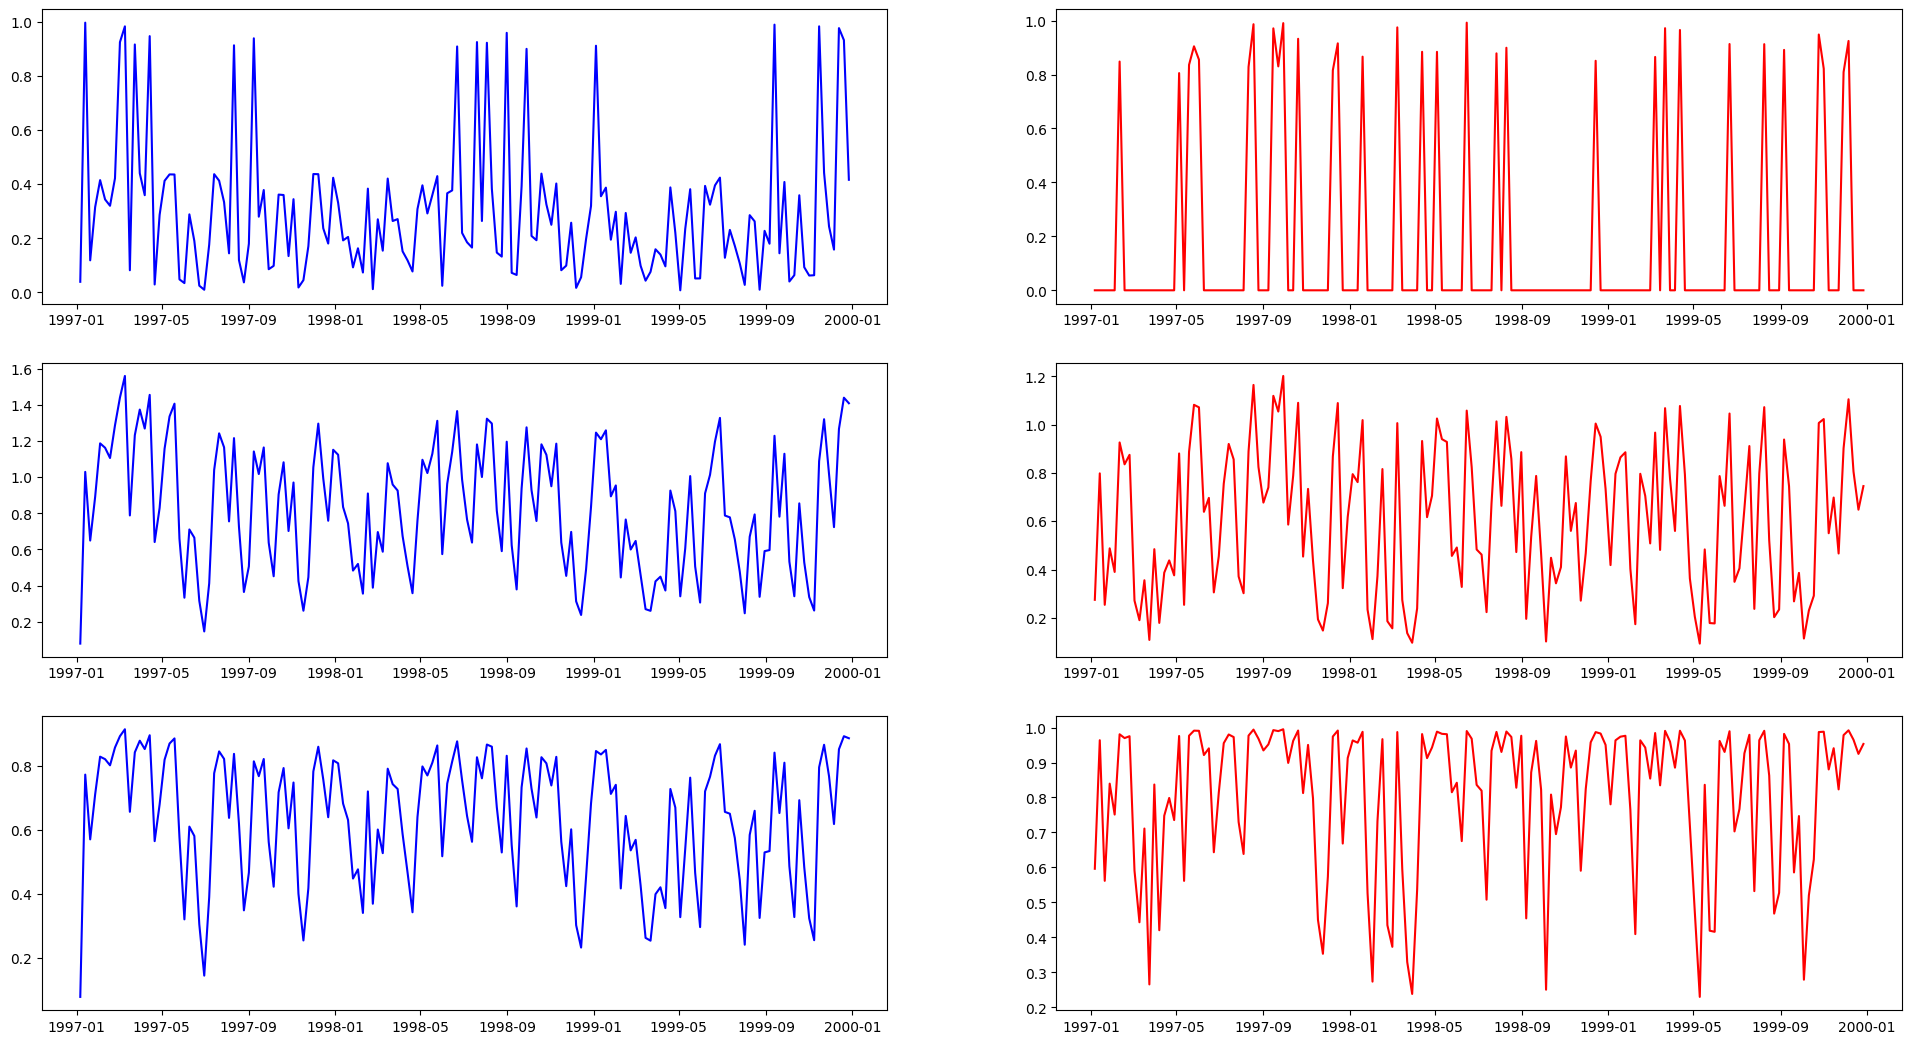

In [5]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(24,13)
)
ax[0,0].plot(df['date_week'], df['x1'], color='blue')
ax[1,0].plot(df['date_week'], df['x1_adstocked'], color='blue')
ax[2,0].plot(df['date_week'], df['x1_sat'], color='blue')
ax[0,1].plot(df['date_week'], df['x2'], color='red')
ax[1,1].plot(df['date_week'], df['x2_adstocked'], color='red')
ax[2,1].plot(df['date_week'], df['x2_sat'], color='red')

For trend we'll use:
$$
\text{trend} = \left(\frac{50 \cdot t}{n} + 10\right)^{\frac{1}{4}} - 1
$$

In [6]:
df['trend'] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1/4) -1

for seasonality we'll do

$$
\begin{align*}
\text{cs} &= -\sin(2 \cdot 2\pi \cdot \frac{\text{doy}}{365.5}) \\
\text{cc} &= \cos(1 \cdot 2\pi \cdot \frac{\text{doy}}{365.5}) \\
\text{seasonality} &= 0.5 \cdot (\text{cs} + \text{cc})
\end{align*}


$$

In [7]:
df["cs"] = -np.sin(2 * 2 * np.pi * df["day_of_year"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["day_of_year"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

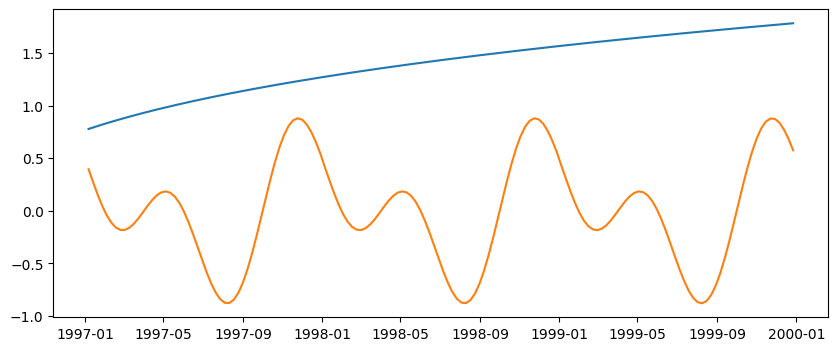

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(df['date_week'], df['trend'])
ax.plot(df['date_week'], df['seasonality'])

In [9]:
# we'll add one event

df['event_1'] = (df['date_week'] == "1997-06-09").astype(float)

In [10]:
# target variable

df['intercept'] = 2.0

df['epsilon'] = rng.normal(size=n)

beta_1 = 3.0
beta_2 = 2.0
beta_event = 1.5
betas = [beta_1, beta_2]

In [11]:
df['y'] = (
    df['intercept'] + 
    df['trend'] + 
    df['seasonality'] + 
    beta_event * df['event_1'] + 
    beta_1 * df['x1_sat'] + 
    beta_2 * df['x2_sat'] + 
    df['epsilon']
)

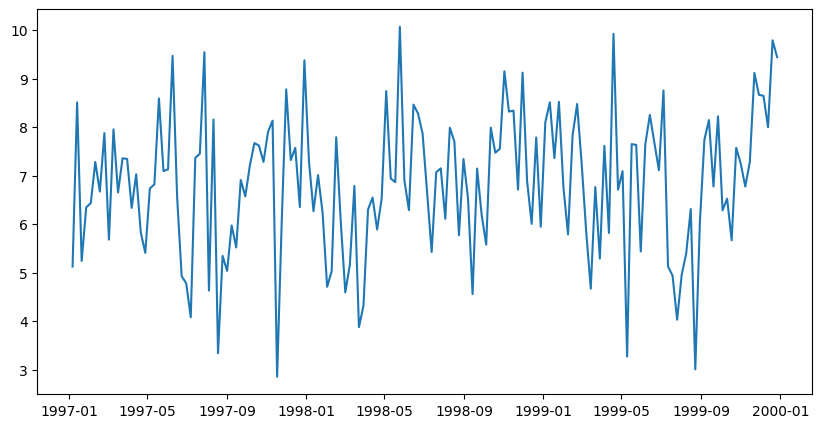

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['date_week'], df['y'])

In [13]:
df[['y', 'x1_sat', 'x2_sat']].corr()

,y,x1_sat,x2_sat
y,1.000000,0.509319,0.405858
x1_sat,0.509319,1.000000,0.178519
x2_sat,0.405858,0.178519,1.000000


In [14]:
coefficients = {
    'intercept': 1,
    'x1_sat': beta_1,
    'x2_sat': beta_2,
    'event_1': beta_event,
    'trend': 1,
    'seasonality': 1
}
media_variables = ['x1_sat', 'x2_sat']
cost_dict = {
    'x1_sat': df['x1_sat_media_cost'].sum(),
    'x2_sat': df['x2_sat_media_cost'].sum()
}

# True Media Contribution

The media contribution is simply the betas over the real values of impressions/spend for all variables.

In [24]:
contrib = Contributions(
    df = df,
    coefficients=coefficients,
    media_variables=media_variables,
    media_cost_dict=cost_dict
)

In [35]:
contrib.

{'x1_sat': np.float64(0.5423522554911955),
 'x2_sat': np.float64(0.4576477445088045)}

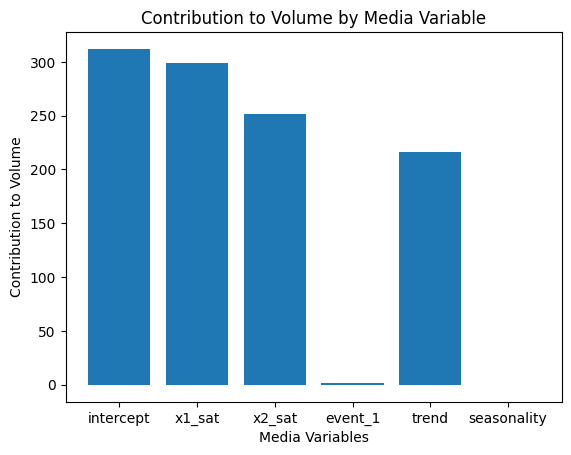

In [25]:
contrib_vol = contrib.contribution_to_volume

fig, ax = plt.subplots()
ax.bar(contrib_vol.keys(), contrib_vol.values())
ax.set_ylabel('Contribution to Volume')
ax.set_xlabel('Media Variables')
ax.set_title('Contribution to Volume by Media Variable')
plt.show()

In [26]:
print(contrib._rel_contribution_to_volume_dict)

None


For calculating the ROI we follow

$$
ROI = \frac{\text{Incremental Contribution}}{\text{Cost}}
$$

In [20]:
print(contrib._roi_dict)

None


$$

# Modeling

We will propose several ways to estimate the MMM, starting with simpler methods to more complex and advanced. However, some methods might include data processing steps.

## Frequentist Linear Regression

For estimating the linear regression we will be using the following formulas:

$$\hat{\boldsymbol{\beta}} = (X^T X)^{-1}X^TY$$
$$\text{SE}(\hat{\boldsymbol{\beta}}) = \sqrt{\text{MSE} \cdot \text{diag}((X^T X)^{-1})}$$
$$\mathbf{t} = \frac{\hat{\boldsymbol{\beta}}}{\text{SE}(\hat{\boldsymbol{\beta}})}$$
$$\mathbf{p}\text{-value} = 2 \cdot [1 - F_{T_{n-p}}(|\mathbf{t}|)]$$
where $\text{MSE} = \frac{\sum_{i=1}^n (y_i - \hat{y}i)^2}{n-p}$ and $F{T_{n-p}}(\cdot)$ is the t-distribution CDF with $n-p$ degrees of freedom.


$$F_T(x, \text{df})=
0.5 \cdot \left(1 + \text{sign}(x) \cdot \sqrt{1 - e^{-\frac{2x^2}{\pi}}}\right)$$

In [52]:
# Create and use the model
model = LinearRegression(df, 'y', ['x1_sat', 'x2_sat', 'event_1', 'trend', 'seasonality'])

# Fit the model
results = model.fit()

# Print summary
model.summary()

Linear Regression Results:
Variable        Coefficient  Std Error    t-value    p-value   
--------------------------------------------------------------------------------
x1_sat          3.554001     0.418058     8.501213   0.00e+00  
x2_sat          2.110368     0.382855     5.512181   1.99e-09  
event_1         2.918834     1.005936     2.901611   0.002353  
trend           0.869718     0.293631     2.961939   0.001878  
seasonality     0.935352     0.160036     5.844629   1.80e-10  
intercept       1.641198     0.569480     2.881924   0.002531  
Degrees of Freedom: 150
Number of Observations: 156


In [53]:
# Get coefficients
coefficients_estimated = model.get_coefficients()

# Addressing goodness of fit

# Model Interpretation

In [58]:
contrib.update_data(coefficients=coefficients_estimated)

<BarContainer object of 6 artists>

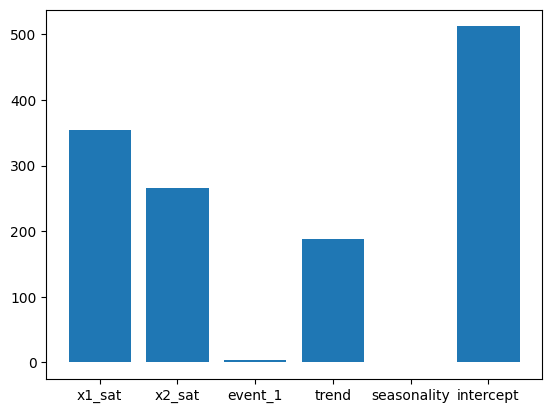

In [60]:
contrib_vol = contrib.contribution_to_volume
fig, ax = plt.subplots()
ax.bar(contrib_vol.keys(), contrib_vol.values())

In [59]:
contrib.rel_contribution_to_volume

{'x1_sat': np.float64(0.5709093563426453),
 'x2_sat': np.float64(0.4290906436573547)}

In [62]:
contrib._roi_dict

In [36]:
class Testing:

    def __init__(self, x:int, y:int) -> None:
        self.x = x
        self.y = y

        self.resultado = None
    def sum(self):

        if self.resultado is None:
            self.resultado = 0
        
        self.resultado = self.x + self.y

        return self.resultado
    
